# EISy Quick Start Tutorial

This notebook demonstrates the basic usage of EISy for Electrochemical Impedance Spectroscopy (EIS) data analysis.

In [1]:
# Import necessary modules

import numpy as np

from eisy.core.fitting import best_model
from eisy.core.parsing import parse_circuit
from eisy.data.synthetic import generate_synthetic_data
from eisy.data.utils import nyquist_plot

In [2]:
# Example 1: Basic circuit evaluation

# Define a simple Randles circuit: R1-(R2|Q1)
circuit = parse_circuit("R1-(R2|Q1)")
print(f"Circuit: {circuit}")

# Define parameters
params = {
    "R1": 100,  # Solution resistance (Ohms)
    "R2": 200,  # Charge transfer resistance (Ohms)
    "Q1": (1e-6, 0.9),  # CPE: (Q in F·s^(α-1), α)
}

# Calculate impedance at a single frequency
freq = 1000  # Hz
Z = circuit.impedance(freq, params)
print(f"\nImpedance at {freq} Hz: {Z:.2f} Ω")
print(f"  Real part (Z'):  {Z.real:.2f} Ω")
print(f"  Imag part (Z''): {Z.imag:.2f} Ω")

Circuit: R1-R2|Q1

Impedance at 1000 Hz: 250.42-71.96j Ω
  Real part (Z'):  250.42 Ω
  Imag part (Z''): -71.96 Ω


Generated 50 data points
Frequency range: 1.0 - 100000.0 Hz
Impedance range: 102.5 - 376.1 Ω


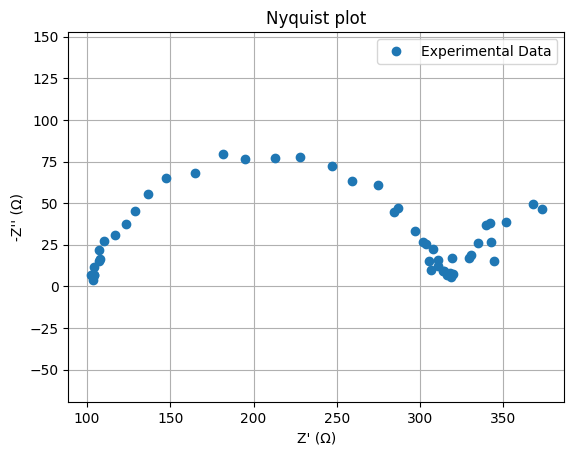

In [3]:
# Example 2: Generate synthetic data with Warburg diffusion

# Define circuit with Warburg diffusion
circuit_string = "R1-(R2-W1)|Q1"

params = {
    "R1": 100,
    "R2": 200,
    "W1": 150,
    "Q1": (1e-6, 0.9),
}

# Generate synthetic data
freq, Z_noisy, Z_true = generate_synthetic_data(
    circuit_string,
    params,
    freq_min=1,
    freq_max=1e5,
    num_points=50,
    noise_level=0.05,
)

print(f"Generated {len(freq)} data points")
print(f"Frequency range: {freq.min():.1f} - {freq.max():.1f} Hz")
print(f"Impedance range: {abs(Z_noisy).min():.1f} - {abs(Z_noisy).max():.1f} Ω")

# Plot the data
nyquist_plot(Z_noisy, label="Synthetic Data with Noise")

Fitting circuit to data...

Fitting complete!
R² = 0.998702

Fitted parameters:
----------------------------------------
R1  : 104.10 (true: 100.00, error: 4.1%)
R2  : 204.28 (true: 200.00, error: 2.1%)
W1  : 125.58 (true: 150.00, error: 16.3%)
Q1  : (np.float64(1.0725721877637755e-06), np.float64(0.8894706867036613))
      True: (1e-06, 0.9)

Generating comparison plot...


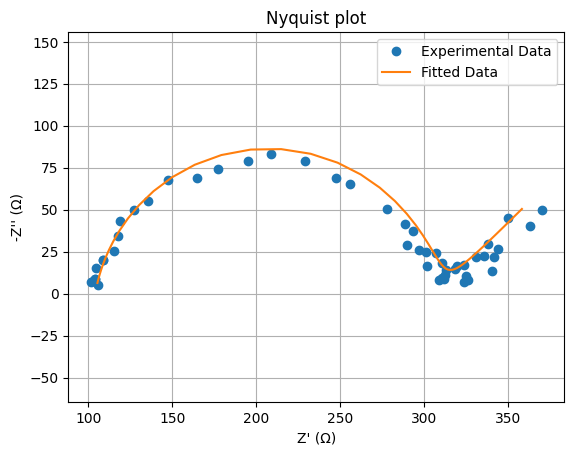

In [4]:
# Example 3: Fit circuit to data

# Generate some "experimental" data
true_circuit = "R1-(R2-W1)|Q1"
true_params = {
    "R1": 100,
    "R2": 200,
    "W1": 150,
    "Q1": (1e-6, 0.9),
}

freq, Z_exp, _ = generate_synthetic_data(
    true_circuit,
    true_params,
    freq_min=1,
    freq_max=1e5,
    num_points=50,
    noise_level=0.05,
)

# Now fit a circuit to this data
circuit = parse_circuit(true_circuit)

# Initial guess (deliberately different from true values)
initial_guess = {
    "R1": 80,
    "R2": 250,
    "W1": 100,
    "Q1": (5e-7, 0.85),
}

print("Fitting circuit to data...")
fitted_params, r_squared = circuit.fit(freq, Z_exp, initial_guess)

print("\nFitting complete!")
print(f"R² = {r_squared:.6f}")
print("\nFitted parameters:")
print("-" * 40)
for param, value in fitted_params.items():
    if param in true_params:
        true_val = true_params[param]
        if isinstance(value, tuple):
            print(f"{param:4s}: {value}")
            print(f"      True: {true_val}")
        else:
            error = abs(value - true_val) / true_val * 100
            print(
                f"{param:4s}: {value:.2f} (true: {true_val:.2f}, error: {error:.1f}%)"
            )

# Generate fitted impedance for plotting
Z_fit = np.array([circuit.impedance(f, fitted_params) for f in freq])

print("\nGenerating comparison plot...")
nyquist_plot(Z_exp, Z_fit, label=["Experimental", "Fitted"])

In [5]:
# Example 4: Compare multiple models to find the best fit

# Generate experimental data from a known circuit
true_circuit = "R1-(R2-W1)|Q1"
true_params = {
    "R1": 100,
    "R2": 200,
    "W1": 150,
    "Q1": (1e-6, 0.9),
}

freq, Z_exp, _ = generate_synthetic_data(
    true_circuit,
    true_params,
    freq_min=1,
    freq_max=1e5,
    num_points=50,
    noise_level=0.05,
)

# Define multiple models to test
models = [
    ("R1-(W1)|Q1", {"R1": 100, "W1": 150, "Q1": (1e-6, 0.9)}),
    ("R1-(R2|Q1)", {"R1": 100, "R2": 200, "Q1": (1e-6, 0.9)}),
    ("R1-(R2-W1)|Q1", {"R1": 100, "R2": 200, "W1": 150, "Q1": (1e-6, 0.9)}),
    ("R1-R2-(R3|C1)", {"R1": 100, "R2": 50, "R3": 150, "C1": 1e-6}),
]

print(f"Testing {len(models)} different circuit models...")
print()

results = []
for circuit_string, initial_params in models:
    circuit = parse_circuit(circuit_string)
    fitted_params, r_squared = circuit.fit(freq, Z_exp, initial_params)
    results.append((circuit_string, r_squared, fitted_params))
    print(f"{circuit_string:20s} R² = {r_squared:.6f}")

# Find best model
best_model_result = max(results, key=lambda x: x[1])
print(f"\nBest model: {best_model_result[0]} (R² = {best_model_result[1]:.6f})")

Testing 4 different circuit models...

R1-(W1)|Q1           R² = 0.987596
R1-(R2|Q1)           R² = 0.991915
R1-(R2-W1)|Q1        R² = 0.998333
R1-R2-(R3|C1)        R² = 0.988773

Best model: R1-(R2-W1)|Q1 (R² = 0.998333)


In [8]:
# Alternatively, use the built-in best_model function
best_fit, best_params = best_model(models, freq, Z_exp)
print("\nUsing best_model() function:")
print(f"Best circuit: {best_fit[0]}")
print(f"Parameters: {best_params}")

Model: R1-(W1)|Q1, R^2: 0.9875960158819164
Model: R1-(R2|Q1), R^2: 0.9919150869512433
Model: R1-(R2-W1)|Q1, R^2: 0.9983327361700685
Model: R1-R2-(R3|C1), R^2: 0.9887733844375247

Using best_model() function:
Best circuit: R1-(R2-W1)|Q1
Parameters: {'R1': np.float64(105.30944336708582), 'R2': np.float64(204.74388885258855), 'W1': np.float64(126.940545546633), 'Q1': (np.float64(1.05313901844561e-06), np.float64(0.893520171600598))}
